This is an exercise for portfolio optimization
-Seek optimized portfolio weights with minimum Volality per target return level



In [68]:

import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
import yfinance as yf

In [69]:
import warnings 
warnings.filterwarnings('ignore')

Define securities and parameters

In [70]:
Num_portfolio = 10 ** 5 #simulate 10^4 possible solutions

tickers = ['SPY','BND','GLD','QQQ','IWM'] #since downloading the return per ticker one by one, no need to sort the ticker list as yFinance sort data per ticker

Num_days = 252 #annualize return 
end_date = datetime.today()
start_date = end_date - timedelta(days = 5*365)

Download Adjusted Closing prices

In [71]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Calculate returns

In [72]:
simple_returns = adj_close_df.pct_change().dropna()
simple_avg_return = simple_returns.mean() * Num_days


Calculate Convariance Matrix

In [73]:
simple_cov = simple_returns.cov() * Num_days
simple_cov

,SPY,BND,GLD,QQQ,IWM
SPY,0.043886,0.002721,0.003577,0.049475,0.049251
BND,0.002721,0.004668,0.003905,0.003340,0.003169
GLD,0.003577,0.003905,0.022379,0.004815,0.004166
QQQ,0.049475,0.003340,0.004815,0.064356,0.052321
IWM,0.049251,0.003169,0.004166,0.052321,0.072136


Download free rate from Fred

In [74]:
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [75]:
from fredapi import Fred

filename = 'apikey'
api_key = get_file_contents(filename)
fred = Fred(api_key=api_key) 
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_year_treasury_rate[-1]
print(risk_free_rate)

0.0421


Define Support functions

Calculate portfolio standard deviation

In [76]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights #https://blog.quantinsti.com/calculating-covariance-matrix-portfolio-variance/#:~:text=In%20finance%2C%20the%20covariance%20matrix,risk%20and%20enhance%20potential%20returns.
    #variance = (np.dot(weights, np.dot(cov_matrix, weights.T)))
    #std = sqrt(variance)
    return np.sqrt(variance)

Calculate portfolio expected returns

In [77]:
def expected_return(weights, simple_avg_return):
    return np.dot(weights, simple_avg_return)

Calculate portfolio Sharpe ratio

In [78]:
def sharpe_ratio(weights, simple_avg_return, cov_matrix, risk_free_rate):
    return (expected_return(weights, simple_avg_return) - risk_free_rate) / standard_deviation(weights, cov_matrix)

Get Negative portfolio sharpe ratio

In [79]:
def neg_sharpe_ratio(weights, simple_avg_return, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, simple_avg_return, cov_matrix, risk_free_rate)

Set constraints and bounds.

1.For each interval in returns target range, optimize portfolio weights with minimum standard deviation. 
2.sum of weight = 1
3.weight >= 0, no shorting


In [80]:
def get_efficient_frontier(simple_avg_return, cov_mat, rtns_range):
    efficient_portfolios = []
    n_assets = len(simple_avg_return)
    args = (cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets)) #bound for each asset from 0 - 100%
    initial_guess = n_assets * [1. / n_assets, ]
    for ret in rtns_range:
        constr = (
            {"type": "eq",
             "fun": lambda x: expected_return(x, simple_avg_return) - ret},
            {"type": "eq",
             "fun": lambda x: np.sum(x) - 1}
        )
        ef_portf = minimize(standard_deviation,
                                initial_guess,
                                args=args, method="SLSQP",
                                constraints=constr,
                                bounds=bounds)
        efficient_portfolios.append(ef_portf)
    return efficient_portfolios

Randomize portfolios and get its standard deviation for chart

In [81]:
np.random.seed(42)
weights = np.random.random(size=(Num_portfolio, len(tickers))) #return random weight size=(shapelike), shapelike = [[weights] * num of portfolio]
weights /=  np.sum(weights, axis=1)[:, np.newaxis] #random weights divided by sum weight to become partial of the total random weight


In [82]:
portf_rtns = expected_return(weights, simple_avg_return)
portf_vol = list()
for i in range(0, len(weights)):
    vol = standard_deviation( weights[i], simple_cov)    
    portf_vol.append(vol)

portf_vol = np.array(portf_vol)
portf_sharpe_ratio = (portf_rtns - risk_free_rate)/ portf_vol

In [83]:
portf_results_df = pd.DataFrame(
    {"returns": portf_rtns,
     "volatility": portf_vol,
     "sharpe_ratio": portf_sharpe_ratio}
)


Setup up return range and optimize portfolio with minimum standard deviation. 1. return range from -0.1 to max return of single stock with highest avg return, evenly by 200 intervals.

In [84]:
#setup return range for optimization.  
#Return from -0.1 to max return of single stock with highest avg return, evenly by 200 intervals

rtns_range = np.linspace(-0.1, simple_avg_return.max(), 200) 


Calculate efficient frontiers per target return

In [85]:
efficient_portfolios = get_efficient_frontier(simple_avg_return,
                                              simple_cov,
rtns_range)

Loop to Extract efficient frontiers volatitly per target return  

In [86]:
vols_range = [x["fun"] for x in efficient_portfolios] # 'fun' function of standard deviation per return value. 'x' is weight 

plot them in chart

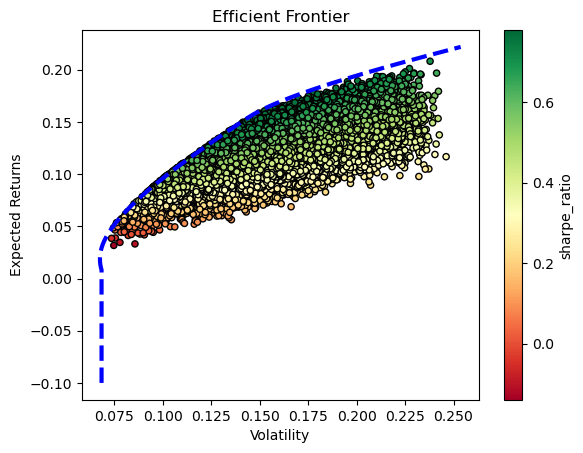

In [87]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
portf_results_df.plot(kind="scatter", x="volatility",
                      y="returns", c="sharpe_ratio",
                      cmap="RdYlGn", edgecolors="black",
                      ax=ax)
ax.plot(vols_range, rtns_range, "b--", linewidth=3)
ax.set(xlabel="Volatility",
       ylabel="Expected Returns",
       title="Efficient Frontier")
plt.show()

In [88]:
max_sharpe_ind = np.argmax(portf_results_df["sharpe_ratio"]) #index of max sharpe ratio portfolio
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]
min_vol_ind = np.argmin(portf_results_df["volatility"]) #index of min volatility portfolio
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [89]:
print("Max Sharpe Ratio portfolio")
print(max_sharpe_portf)

print( [{'Sym': Sym, 'weight': weight} for Sym, weight in zip(tickers, weights[max_sharpe_ind])])


print("Minimum Volatility portfolio")
print(min_vol_portf)
print( [{'Sym': Sym, 'weight': weight} for Sym, weight in zip(tickers, weights[min_vol_ind])])

Max Sharpe Ratio portfolio
returns         0.162876
volatility      0.155022
sharpe_ratio    0.779089
Name: 84542, dtype: float64
[{'Sym': 'SPY', 'weight': 0.0312732084745218}, {'Sym': 'BND', 'weight': 0.013070017003604271}, {'Sym': 'GLD', 'weight': 0.4678910832120667}, {'Sym': 'QQQ', 'weight': 0.47721558846992446}, {'Sym': 'IWM', 'weight': 0.010550102839882803}]
Minimum Volatility portfolio
returns         0.038467
volatility      0.073473
sharpe_ratio   -0.049442
Name: 53374, dtype: float64
[{'Sym': 'SPY', 'weight': 0.010383663913753286}, {'Sym': 'BND', 'weight': 0.7205547368827893}, {'Sym': 'GLD', 'weight': 0.23855590035833155}, {'Sym': 'QQQ', 'weight': 0.014084671925243512}, {'Sym': 'IWM', 'weight': 0.01642102691988239}]
